In [1]:
import math

from matplotlib import pyplot as plt
from torch import Tensor

from src.common.log import logger
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import (
    TotalEmissionsCompressedSensingExperiment,
)
from src.inverse_problems.footprints.footprint_loader import load_gaussian_plume_footprint
from src.inverse_problems.inverse_problems_solver import (
    BasisPursuitSolver,
    SparsityTransform,
    GenerativeModelSolver,
    LeastSquaresSolver,
)
from src.models.common.metrics import relative_error

In [2]:
CITY = "Munich"

x = TnoDatasetCollection().get_single_case_study_city_emission_field(city=CITY, year=2018).sum(dim=0)

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                          
	Aachen, Gdynia, Duisburg, Großzschocher, Dresden, Siegen, Reims, Szczecin, Magdeburg, Prague, Győr, Hamburg, Innsbruck
[INFO] > Validation Set has 15 unique cites!
	Linz, Ingolstadt, Zielona Góra, Kalisz, Koblenz, Wałbrzych, Southampton, Nijmegen, Frankfurt am Main, Bydgoszcz, Brussels, Erfurt, Angers, Bielefeld, Kassel
[INFO] > Training Set has 74 unique cites!
	Gorzów Wielkopolski, Besançon, Antwerpen, Le Mans, Brno, Norwich, Pilsen, Stuttgart, Amiens, Orléans, Dijon, Odense, Freiburg, Mannheim, Rotterdam, Köln, Wrocław, Würzburg, Berlin, Reading, Brugge, Milton Keynes, Ulm, Liberec, Augsburg, Karlsruhe, Ipswich, Münster, Brighton, 

In [3]:
sensing_matrix = load_gaussian_plume_footprint(num_stations=30)

In [4]:
ls_solver = LeastSquaresSolver()

bp_solver = BasisPursuitSolver()
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

In [5]:
snr_db_list = [5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]

In [6]:
ls_reconstruction = []
sparse_reconstruction = []
sparse_reconstruction_dwt = []
sparse_reconstruction_dct = []

for snr_db in snr_db_list:
    snr = math.pow(10, snr_db / 10)
    problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
        x,
        Tensor(sensing_matrix),
        snr=snr
    )
    ls_reconstruction.append(relative_error(x, problem.solve(ls_solver)))
    sparse_reconstruction.append(relative_error(x, problem.solve(bp_solver)))
    sparse_reconstruction_dwt.append(relative_error(x, problem.solve(bp_solver_dwt)))
    sparse_reconstruction_dct.append(relative_error(x, problem.solve(bp_solver_dct)))
    logger.info(f"SNR {snr} done!")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-01
[INFO] > SNR 3.1622776601683795 done!
[INFO] > SNR 6.309573444801933 done!
[INFO] > SNR 12.589254117941675 done!
[INFO] > SNR 25.118864315095795 done!
[INFO] > SNR 50.11872336272722 done!
[INFO] > SNR 100.0 done!
[INFO] > SNR 199.52623149688787 done!
[INFO] > SNR 398.1071705534973 done!
[INFO] > SNR 794.3282347242813 done!
[INFO] > SNR 1584.893192461114 done!
[INFO] > SNR 3162.2776601683795 done!
[INFO] > SNR 6309.57344480193 done!


[tensor(0.5495), tensor(0.5281), tensor(0.5199), tensor(0.5098), tensor(0.4914), tensor(0.4775), tensor(0.4642), tensor(0.4585), tensor(0.4430), tensor(0.4409), tensor(0.4336), tensor(0.4205)]


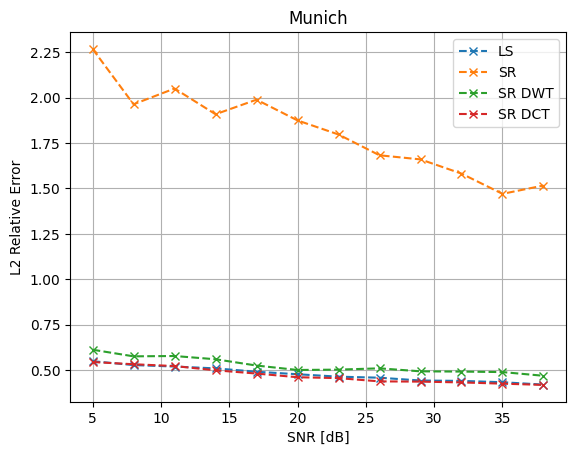

In [10]:
plt.plot(snr_db_list, ls_reconstruction, "x--", label="LS")
plt.plot(snr_db_list, sparse_reconstruction, "x--", label="SR")
plt.plot(snr_db_list, sparse_reconstruction_dwt, "x--", label="SR DWT")
plt.plot(snr_db_list, sparse_reconstruction_dct, "x--", label="SR DCT")

print(ls_reconstruction)
plt.xlabel("SNR [dB]")
plt.ylabel("L2 Relative Error")

plt.title("Munich")
plt.grid()

plt.legend()

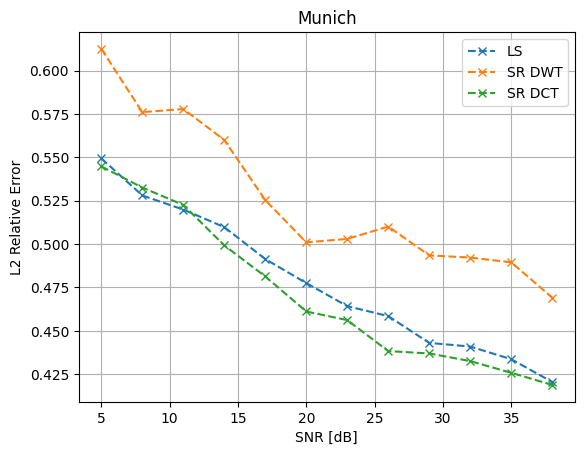

In [11]:
plt.plot(snr_db_list, ls_reconstruction, "x--", label="LS")
plt.plot(snr_db_list, sparse_reconstruction_dwt, "x--", label="SR DWT")
plt.plot(snr_db_list, sparse_reconstruction_dct, "x--", label="SR DCT")

plt.xlabel("SNR [dB]")
plt.ylabel("L2 Relative Error")

plt.title("Munich")
plt.grid()

plt.legend()